In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pickle

# Data Preprocessing

Reading the Data

In [27]:
btc_df = pd.read_csv('data/BTC-USD.csv')
int_rate_df = pd.read_csv('data/^TNX.csv')
nyse_df = pd.read_csv('data/^NYA.csv')
gold_df = pd.read_csv('data/^XAU.csv')
nasdaq_df = pd.read_csv('data/^NDX.csv')


Turn the Data into Time Series'

In [28]:
nyse_df.index = pd.to_datetime(nyse_df.Date)
nyse_df_ts = nyse_df.drop('Date', axis=1).Close

int_rate_df.index = pd.to_datetime(int_rate_df.Date)
int_rate_df_ts = int_rate_df.drop('Date', axis=1).Close

gold_df.index = pd.to_datetime(gold_df.Date)
gold_df_ts = gold_df.drop('Date', axis=1).Close

nasdaq_df.index = pd.to_datetime(nasdaq_df.Date)
nasdaq_df_ts = nasdaq_df.drop('Date', axis=1).Close

In [29]:
btc_df.index = pd.to_datetime(btc_df.Date)
btc_df_ts = btc_df.drop('Date', axis=1)

temp = btc_df_ts[['Close']].join(nyse_df_ts, lsuffix='_btc', rsuffix='_nyse', how='left')
temp = temp.join(int_rate_df_ts, rsuffix='_int_rate', how='left')
temp = temp.join(gold_df_ts, lsuffix='_int_rate', rsuffix='_gold', how='left')
df_cumulative = temp.join(nasdaq_df_ts, lsuffix='_gold', rsuffix='_nasdaq', how='left')
df_cumulative.columns = ['BTC', 'NYSE', 'Int_Rate', 'Gold', 'Nasdaq']

In [30]:
df_cumulative.isna().sum()

BTC           0
NYSE        847
Int_Rate    850
Gold        846
Nasdaq      846
dtype: int64

In [31]:
df_cumulative.fillna(method='ffill', inplace=True)

In [32]:
df_cumulative.isna().sum()

BTC         0
NYSE        0
Int_Rate    0
Gold        0
Nasdaq      0
dtype: int64

Train-Test Split

In [33]:
df_cumulative

,BTC,NYSE,Int_Rate,Gold,Nasdaq
Date,,,,,
2014-09-17,457.334015,10973.740234,2.600,90.430000,4073.570068
2014-09-18,424.440002,11024.059570,2.629,89.139999,4103.080078
2014-09-19,394.795990,10989.570313,2.587,86.930000,4100.089844
2014-09-20,408.903992,10989.570313,2.587,86.930000,4100.089844
2014-09-21,398.821014,10989.570313,2.587,86.930000,4100.089844
...,...,...,...,...,...
2022-02-25,39214.218750,16427.960938,1.986,142.940002,14189.160156
2022-02-26,39105.148438,16427.960938,1.986,142.940002,14189.160156
2022-02-27,37709.785156,16427.960938,1.986,142.940002,14189.160156


In [38]:
df_cumulative.to_csv('dataframes/df_cumulative.csv')

In [21]:
size = int(len(df_cumulative) * .85)
train = df_cumulative.iloc[:size,]
test = df_cumulative.iloc[size:,]
train_scaled = train.copy() # to be chaged with scaled values
test_scaled = test.copy() # to be chaged with scaled values

Scaling the Data

In [22]:
btc_scaler = MinMaxScaler(feature_range=(0,1))
btc_train = btc_scaler.fit_transform(train.BTC.values.reshape(-1,1))
train_scaled.BTC = btc_train
btc_test = btc_scaler.transform(test.BTC.values.reshape(-1,1))
test_scaled.BTC = btc_test

nyse_scaler = MinMaxScaler(feature_range=(0,1))
nyse_train = nyse_scaler.fit_transform(train.NYSE.values.reshape(-1,1))
train_scaled.NYSE = nyse_train
nyse_test = nyse_scaler.transform(test.NYSE.values.reshape(-1,1))
test_scaled.NYSE = nyse_test

gold_scaler = MinMaxScaler(feature_range=(0,1))
gold_train = gold_scaler.fit_transform(train.Gold.values.reshape(-1,1))
train_scaled.Gold = gold_train
gold_test = gold_scaler.transform(test.Gold.values.reshape(-1,1))
test_scaled.Gold = gold_test

nasdaq_scaler = MinMaxScaler(feature_range=(0,1))
nasdaq_train = nasdaq_scaler.fit_transform(train.Nasdaq.values.reshape(-1,1))
train_scaled.Nasdaq = nasdaq_train
nasdaq_test = nasdaq_scaler.transform(test.Nasdaq.values.reshape(-1,1))
test_scaled.Nasdaq = nasdaq_test

int_rate_scaler = StandardScaler()
int_rate_train = int_rate_scaler.fit_transform(train.Int_Rate.values.reshape(-1,1))
train_scaled.Int_Rate = int_rate_train
int_rate_test = int_rate_scaler.transform(test.Int_Rate.values.reshape(-1,1))
test_scaled.Int_Rate = int_rate_test

In [23]:
train_scaled

,BTC,NYSE,Int_Rate,Gold,Nasdaq
Date,,,,,
2014-09-17,0.006874,0.350464,0.846459,0.421832,0.033008
2014-09-18,0.006065,0.358494,0.890644,0.411284,0.036167
2014-09-19,0.005335,0.352990,0.826652,0.393213,0.035847
2014-09-20,0.005682,0.352990,0.826652,0.393213,0.035847
2014-09-21,0.005434,0.352990,0.826652,0.393213,0.035847
...,...,...,...,...,...
2021-01-12,0.830755,0.994560,-1.381067,0.865904,0.977183
2021-01-13,0.914296,0.990303,-1.457248,0.846198,0.985913
2021-01-14,0.960357,1.000000,-1.394779,0.852249,0.977890


In [24]:
test_scaled

,BTC,NYSE,Int_Rate,Gold,Nasdaq
Date,,,,,
2021-01-17,0.876751,0.976032,-1.443535,0.806787,0.967744
2021-01-18,0.897401,0.976032,-1.443535,0.806787,0.967744
2021-01-19,0.883608,0.990898,-1.451153,0.818970,0.988366
2021-01-20,0.870755,1.008441,-1.454201,0.853639,1.020477
2021-01-21,0.754504,0.995958,-1.425252,0.837285,1.032098
...,...,...,...,...,...
2022-02-25,0.961019,1.220772,-0.089041,0.851186,1.116057
2022-02-26,0.958334,1.220772,-0.089041,0.851186,1.116057
2022-02-27,0.923982,1.220772,-0.089041,0.851186,1.116057


# RNN Models

## Baseline Models

In [16]:
baseline_train = train_scaled['BTC'].values.reshape(-1,1)
baseline_test = test_scaled['BTC'].values.reshape(-1,1)

In [17]:
X_train = []
y_train = []
for i in range(60,len(baseline_train)):
    X_train.append(baseline_train[i-60:i])
    y_train.append(baseline_train[i])

baseline_test_data_total = np.concatenate((baseline_train,baseline_test))[len(train_scaled)-60:]

X_test = []
y_test = []
for i in range(60,len(baseline_test_data_total)):
    X_test.append(baseline_test_data_total[i-60:i])
    y_test.append(baseline_test_data_total[i])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2254, 60, 1), (2254, 1), (409, 60, 1), (409, 1))

Models

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1802/1803 [============================>.] - ETA: 0s - loss: 7.7281e-04
Epoch 00001: val_loss improved from inf to 0.00157, saving model to models/rnn_baseline_dropout.hdf5
1803/1803 [==============================] - 15s 8ms/step - loss: 7.7379e-04 - val_loss: 0.0016
Epoch 2/50
1800/1803 [============================>.] - ETA: 0s - loss: 3.0806e-04
Epoch 00002: val_

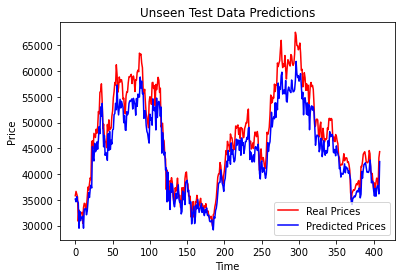

In [69]:
#Init the model
rnn_baseline_dropout = Sequential()

#Layers
rnn_baseline_dropout.add(LSTM(units= 60, return_sequences = False, input_shape=(X_train.shape[1:])))
rnn_baseline_dropout.add(Dropout(0.2))
rnn_baseline_dropout.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.001)
rnn_baseline_dropout.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_baseline_dropout.summary()

#Save the best model
filepath = 'models/rnn_baseline_dropout.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_baseline_dropout.fit(X_train, y_train, epochs=50, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_baseline_dropout.hdf5'
rnn_best_baseline_dropout = load_model(load_file)

#Predict on test data
y_hat_raw_dropout = rnn_best_baseline_dropout.predict(X_test)
y_hat_baseline_dropout = btc_scaler.inverse_transform(y_hat_raw_dropout)
y_test_unscaled = btc_scaler.inverse_transform(y_test)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_baseline_dropout, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
lstm_7 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 43,981
Trainable params: 43,981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1802/1803 [============================>.] - ETA: 0s - loss: 4.3338e-04
Epoch 00001: val_loss improved from inf to 0.00123, saving model to models/rnn_baseline_2_layer.hdf5
1803/1803 [==============================] - 30s 17ms/step - loss: 4.3317e-04 - val_loss: 0.0012
Epoch 2/50
1801/1803 [============================>.] - ETA: 0s - loss: 2.0851e-04
Epoch 00002: val

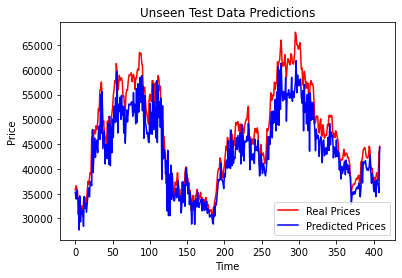

In [70]:
#Init the model
rnn_baseline_2_layer = Sequential()

#Layers
rnn_baseline_2_layer.add(LSTM(units= 60, return_sequences = True, input_shape=(X_train.shape[1:])))
rnn_baseline_2_layer.add(LSTM(units= 60, return_sequences = False))

rnn_baseline_2_layer.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.001)
rnn_baseline_2_layer.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_baseline_2_layer.summary()

#Save the best model
filepath = 'models/rnn_baseline_2_layer.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_baseline_2_layer.fit(X_train, y_train, epochs=50, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_baseline_2_layer.hdf5'
rnn_best_baseline_2_layer = load_model(load_file)

#Predict on test data
y_hat_raw_2_layer = rnn_best_baseline_2_layer.predict(X_test)
y_hat_baseline_2_layer = btc_scaler.inverse_transform(y_hat_raw_2_layer)
y_test_unscaled = btc_scaler.inverse_transform(y_test)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_baseline_2_layer, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1803/1803 [==============================] - ETA: 0s - loss: 3.6054e-04
Epoch 00001: val_loss improved from inf to 0.00066, saving model to models/rnn_baseline.hdf5
1803/1803 [==============================] - 15s 8ms/step - loss: 3.6054e-04 - val_loss: 6.5760e-04
Epoch 2/50
1800/1803 [============================>.] - ETA: 0s - loss: 1.6134e-04
Epoch 00002: val_loss improved from 0.00066 to 0.00056, saving model to models/rnn_baseline.hdf5
1803/1803 [==============================] - 15s 8ms/step 

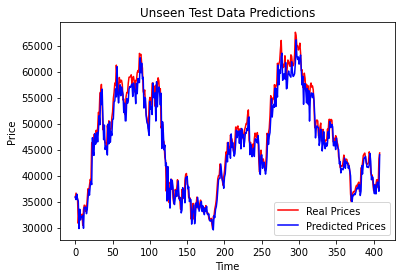

In [18]:
#Init the model
rnn_baseline = Sequential()

#Layers
rnn_baseline.add(LSTM(units= 60, return_sequences = False, input_shape=(X_train.shape[1:])))
rnn_baseline.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.001)
rnn_baseline.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_baseline.summary()

#Save the best model
filepath = 'models/rnn_baseline.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_baseline.fit(X_train, y_train, epochs=50, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_baseline.hdf5'
rnn_best_baseline = load_model(load_file)

#Predict on test data
y_hat_raw = rnn_best_baseline.predict(X_test)
y_hat_baseline = btc_scaler.inverse_transform(y_hat_raw)
y_test_unscaled = btc_scaler.inverse_transform(y_test)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_baseline, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

## Model with NYSE Closings

In [20]:
nyse_train = train_scaled[['BTC','NYSE']].values.reshape(-1,2)
nyse_test = test_scaled[['BTC','NYSE']].values.reshape(-1,2)

In [21]:
X_train_nyse = []
y_train_nyse = []
for i in range(60,len(nyse_train)):
    X_train_nyse.append(nyse_train[i-60:i])
    y_train_nyse.append(nyse_train[i][0])

nyse_test_data_total = np.concatenate((nyse_train,nyse_test))[len(train_scaled)-60:]

X_test_nyse = []
y_test_nyse = []
for i in range(60,len(nyse_test_data_total)):
    X_test_nyse.append(nyse_test_data_total[i-60:i])
    y_test_nyse.append(nyse_test_data_total[i][0])
X_train_nyse = np.array(X_train_nyse)
y_train_nyse = np.array(y_train_nyse).reshape(-1,1)
X_test_nyse = np.array(X_test_nyse)
y_test_nyse = np.array(y_test_nyse).reshape(-1,1)

In [22]:
X_train_nyse.shape, y_train_nyse.shape, X_test_nyse.shape, y_test_nyse.shape

((2254, 60, 2), (2254, 1), (409, 60, 2), (409, 1))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1799/1803 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00001: val_loss improved from inf to 0.00153, saving model to models/rnn_nyse.hdf5
1803/1803 [==============================] - 15s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2/100
1801/1803 [============================>.] - ETA: 0s - loss: 3.0535e-04
Epoch 00002: val_loss improved from 0.00153 to 0.00109, saving model to models/rnn_nyse.hdf5
1803/1803 [==============================] - 16s 9ms/step - loss: 3.0502e-

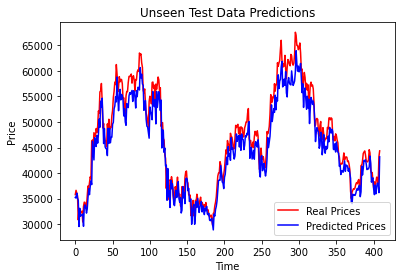

In [36]:
#Init the model
rnn_nyse = Sequential()

#Layers
rnn_nyse.add(LSTM(units= 120, return_sequences = False, input_shape=(X_train_nyse.shape[1:])))
rnn_nyse.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.0001)
rnn_nyse.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_nyse.summary()

#Save the best model
filepath = 'models/rnn_nyse.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_nyse.fit(X_train_nyse, y_train_nyse, epochs=100, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_nyse.hdf5'
rnn_best_nyse = load_model(load_file)

#Predict on test data
y_hat_raw_nyse = rnn_best_nyse.predict(X_test_nyse)
y_hat_nyse = btc_scaler.inverse_transform(y_hat_raw_nyse)
y_test_unscaled = btc_scaler.inverse_transform(y_test_nyse)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_nyse, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

## Model with Int_Rate Closings

In [28]:
int_train = train_scaled[['BTC','Int_Rate']].values.reshape(-1,2)
int_test = test_scaled[['BTC','Int_Rate']].values.reshape(-1,2)

In [29]:
X_train_int = []
y_train_int = []
for i in range(60,len(int_train)):
    X_train_int.append(int_train[i-60:i])
    y_train_int.append(int_train[i][0])

int_test_data_total = np.concatenate((int_train,int_test))[len(train_scaled)-60:]

X_test_int = []
y_test_int = []
for i in range(60,len(int_test_data_total)):
    X_test_int.append(int_test_data_total[i-60:i])
    y_test_int.append(int_test_data_total[i][0])
X_train_int = np.array(X_train_int)
y_train_int = np.array(y_train_int).reshape(-1,1)
X_test_int = np.array(X_test_int)
y_test_int = np.array(y_test_int).reshape(-1,1)

In [30]:
X_train_int.shape, y_train_int.shape, X_test_int.shape, y_test_int.shape

((2254, 60, 2), (2254, 1), (409, 60, 2), (409, 1))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1801/1803 [============================>.] - ETA: 0s - loss: 8.9000e-04
Epoch 00001: val_loss improved from inf to 0.00406, saving model to models/rnn_int.hdf5
1803/1803 [==============================] - 15s 8ms/step - loss: 8.8904e-04 - val_loss: 0.0041
Epoch 2/100
1796/1803 [============================>.] - ETA: 0s - loss: 2.5277e-04
Epoch 00002: val_loss did not improve from 0.00406
1803/1803 [==============================] - 14s 8ms/step - loss: 2.5195e-04 - val_loss: 0.0045
Epoch 3/100
1

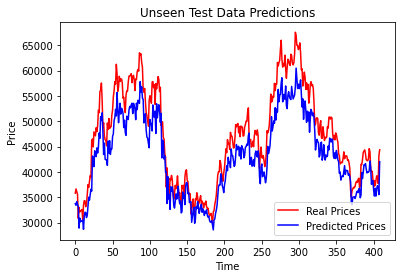

In [40]:
#Init the model
rnn_int = Sequential()

#Layers
rnn_int.add(LSTM(units= 120, return_sequences = False, input_shape=(X_train_int.shape[1:])))
rnn_int.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.0001)
rnn_int.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_int.summary()

#Save the best model
filepath = 'models/rnn_int.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_int.fit(X_train_int, y_train_int, epochs=100, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_int.hdf5'
rnn_best_int = load_model(load_file)

#Predict on test data
y_hat_raw_int = rnn_best_int.predict(X_test_int)
y_hat_int = btc_scaler.inverse_transform(y_hat_raw_int)
y_test_unscaled = btc_scaler.inverse_transform(y_test_int)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_int, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

In [176]:
error_int_mse = np.mean(np.absolute(((y_hat_int-y_test_unscaled)/y_test_unscaled)))

## Model with Gold Closings

In [35]:
gold_train = train_scaled[['BTC','Gold']].values.reshape(-1,2)
gold_test = test_scaled[['BTC','Gold']].values.reshape(-1,2)

In [36]:
X_train_gold = []
y_train_gold = []
for i in range(60,len(gold_train)):
    X_train_gold.append(gold_train[i-60:i])
    y_train_gold.append(gold_train[i][0])

gold_test_data_total = np.concatenate((gold_train,gold_test))[len(train_scaled)-60:]

X_test_gold = []
y_test_gold = []
for i in range(60,len(gold_test_data_total)):
    X_test_gold.append(gold_test_data_total[i-60:i])
    y_test_gold.append(gold_test_data_total[i][0])
X_train_gold = np.array(X_train_gold)
y_train_gold = np.array(y_train_gold).reshape(-1,1)
X_test_gold = np.array(X_test_gold)
y_test_gold = np.array(y_test_gold).reshape(-1,1)

In [37]:
X_train_gold.shape, y_train_gold.shape, X_test_gold.shape, y_test_gold.shape

((2254, 60, 2), (2254, 1), (409, 60, 2), (409, 1))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 120)               59040     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 121       
Total params: 59,161
Trainable params: 59,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1801/1803 [============================>.] - ETA: 0s - loss: 5.3498e-04
Epoch 00001: val_loss improved from inf to 0.00077, saving model to models/rnn_gold.hdf5
1803/1803 [==============================] - 20s 11ms/step - loss: 5.3440e-04 - val_loss: 7.6955e-04
Epoch 2/50
1799/1803 [============================>.] - ETA: 0s - loss: 2.2005e-04
Epoch 00002: val_loss improved from 0.00077 to 0.00075, saving model to models/rnn_gold.hdf5
1803/1803 [==============================] - 19s 11ms/step - lo

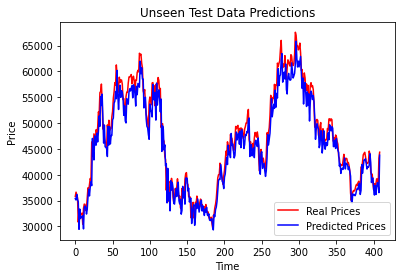

In [135]:
#Init the model
rnn_gold = Sequential()

#Layers
rnn_gold.add(LSTM(units= 120, return_sequences = False, input_shape=(X_train_gold.shape[1:])))
rnn_gold.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.0001)
rnn_gold.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_gold.summary()

#Save the best model
filepath = 'models/rnn_gold.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_gold.hdf5'
rnn_best_gold = load_model(load_file)

#Predict on test data
y_hat_raw_gold = rnn_best_gold.predict(X_test_gold)
y_hat_gold = btc_scaler.inverse_transform(y_hat_raw_gold)
y_test_unscaled = btc_scaler.inverse_transform(y_test_gold)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_gold, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

## Model with Nasdaq Closings

In [38]:
nasdaq_train = train_scaled[['BTC','Nasdaq']].values.reshape(-1,2)
nasdaq_test = test_scaled[['BTC','Nasdaq']].values.reshape(-1,2)

In [39]:
X_train_nasdaq = []
y_train_nasdaq = []
for i in range(60,len(nasdaq_train)):
    X_train_nasdaq.append(nasdaq_train[i-60:i])
    y_train_nasdaq.append(nasdaq_train[i][0])

nasdaq_test_data_total = np.concatenate((nasdaq_train,nasdaq_test))[len(train_scaled)-60:]

X_test_nasdaq = []
y_test_nasdaq = []
for i in range(60,len(nasdaq_test_data_total)):
    X_test_nasdaq.append(nasdaq_test_data_total[i-60:i])
    y_test_nasdaq.append(nasdaq_test_data_total[i][0])
X_train_nasdaq = np.array(X_train_nasdaq)
y_train_nasdaq = np.array(y_train_nasdaq).reshape(-1,1)
X_test_nasdaq = np.array(X_test_nasdaq)
y_test_nasdaq = np.array(y_test_nasdaq).reshape(-1,1)

In [40]:
X_test_nasdaq[0].shape

(60, 2)

In [41]:
X_train_nasdaq.shape, y_train_nasdaq.shape, X_test_nasdaq.shape, y_test_nasdaq.shape

((2254, 60, 2), (2254, 1), (409, 60, 2), (409, 1))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 120)               59040     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 121       
Total params: 59,161
Trainable params: 59,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1803/1803 [==============================] - ETA: 0s - loss: 6.8935e-04
Epoch 00001: val_loss improved from inf to 0.00093, saving model to models/rnn_nasdaq.hdf5
1803/1803 [==============================] - 19s 10ms/step - loss: 6.8935e-04 - val_loss: 9.3186e-04
Epoch 2/50
1799/1803 [============================>.] - ETA: 0s - loss: 2.1472e-04
Epoch 00002: val_loss improved from 0.00093 to 0.00079, saving model to models/rnn_nasdaq.hdf5
1803/1803 [==============================] - 18s 10ms/step 

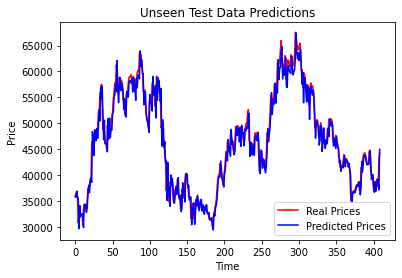

In [139]:
#Init the model
rnn_nasdaq = Sequential()

#Layers
rnn_nasdaq.add(LSTM(units= 120, return_sequences = False, input_shape=(X_train_nasdaq.shape[1:])))
rnn_nasdaq.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.0001)
rnn_nasdaq.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_nasdaq.summary()

#Save the best model
filepath = 'models/rnn_nasdaq.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_nasdaq.fit(X_train_nasdaq, y_train_nasdaq, epochs=50, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_nasdaq.hdf5'
rnn_best_nasdaq = load_model(load_file)

#Predict on test data
y_hat_raw_nasdaq = rnn_best_nasdaq.predict(X_test_nasdaq)
y_hat_nasdaq = btc_scaler.inverse_transform(y_hat_raw_nasdaq)
y_test_unscaled = btc_scaler.inverse_transform(y_test_nasdaq)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_nasdaq, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

## RNN Comprehensive Model

In [42]:
comp_train = train_scaled.values.reshape(-1,5)
comp_test = test_scaled.values.reshape(-1,5)

In [43]:
comp_train.shape, 

((2314, 5),)

In [44]:
X_train_comp = []
y_train_comp = []
for i in range(60,len(comp_train)):
    X_train_comp.append(comp_train[i-60:i])
    y_train_comp.append(comp_train[i][0])

comp_test_data_total = np.concatenate((comp_train,comp_test))[len(train_scaled)-60:]

X_test_comp = []
y_test_comp = []
for i in range(60,len(comp_test_data_total)):
    X_test_comp.append(comp_test_data_total[i-60:i])
    y_test_comp.append(comp_test_data_total[i][0])
X_train_comp = np.array(X_train_comp)
y_train_comp = np.array(y_train_comp).reshape(-1,1)
X_test_comp = np.array(X_test_comp)
y_test_comp = np.array(y_test_comp).reshape(-1,1)

In [45]:
X_train_comp.shape, y_train_comp.shape, X_test_comp.shape, y_test_comp.shape

((2254, 60, 5), (2254, 1), (409, 60, 5), (409, 1))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 300)               367200    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 301       
Total params: 367,501
Trainable params: 367,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1801/1803 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00393, saving model to models/rnn_comp.hdf5
1803/1803 [==============================] - 45s 25ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 2/100
1802/1803 [============================>.] - ETA: 0s - loss: 3.4346e-04
Epoch 00002: val_loss improved from 0.00393 to 0.00157, saving model to models/rnn_comp.hdf5
1803/1803 [==============================] - 42s 23ms/step - loss: 3.4

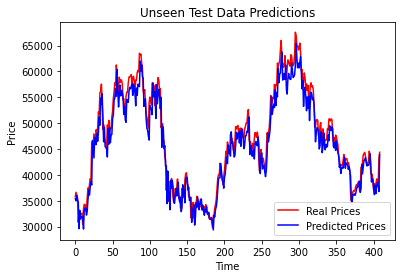

In [174]:
#Init the model
rnn_comp = Sequential()

#Layers
rnn_comp.add(LSTM(units= 300, return_sequences = False, input_shape=(X_train_comp.shape[1:])))
rnn_comp.add(Dense(units=1))

#Compile
opt = Adam(lr = 0.0001)
rnn_comp.compile(optimizer= opt, loss='mean_squared_error')

#Summary
rnn_comp.summary()

#Save the best model
filepath = 'models/rnn_comp.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

#Fit
rnn_comp.fit(X_train_comp, y_train_comp, epochs=100, batch_size=1, validation_split=0.2, callbacks=callbacks)

#Load the saved best model
load_file = 'models/rnn_comp.hdf5'
rnn_best_comp = load_model(load_file)

#Predict on test data
y_hat_raw_comp = rnn_best_comp.predict(X_test_comp)
y_hat_comp = btc_scaler.inverse_transform(y_hat_raw_comp)
y_test_unscaled = btc_scaler.inverse_transform(y_test_comp)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_comp, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

# Results - MAPE

Baseline

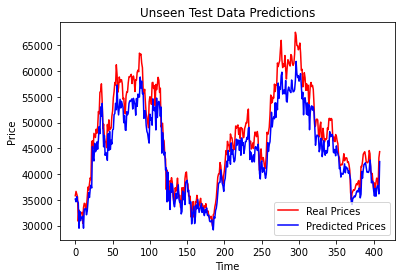

In [19]:
#Baseline 2/ dropout

#Load the saved best model
load_file = 'models/rnn_baseline_dropout.hdf5'
rnn_best_baseline_dropout = load_model(load_file)

#Predict on test data
y_hat_raw_dropout = rnn_best_baseline_dropout.predict(X_test)
y_hat_baseline_dropout = btc_scaler.inverse_transform(y_hat_raw_dropout)
y_test_unscaled = btc_scaler.inverse_transform(y_test)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_baseline_dropout, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;
error_baseline_w_dropout = np.mean(np.absolute(((y_hat_baseline_dropout-y_test_unscaled)/y_test_unscaled)))

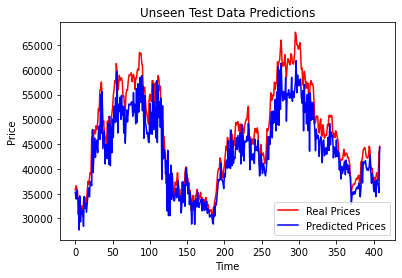

In [23]:
# Baseline w/ 2 Layers

#Load the saved best model
load_file = 'models/rnn_baseline_2_layer.hdf5'
rnn_best_baseline_2_layer = load_model(load_file)

#Predict on test data
y_hat_raw_2_layer = rnn_best_baseline_2_layer.predict(X_test)
y_hat_baseline_2_layer = btc_scaler.inverse_transform(y_hat_raw_2_layer)
y_test_unscaled = btc_scaler.inverse_transform(y_test)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_baseline_2_layer, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;
error_baseline_2_layer = np.mean(np.absolute(((y_hat_baseline_2_layer-y_test_unscaled)/y_test_unscaled)))

In [24]:
# Baseline

#Load the saved best model
load_file = 'models/rnn_baseline.hdf5'
rnn_best_baseline = load_model(load_file)

#Predict on test data
y_hat_raw = rnn_best_baseline.predict(X_test)
y_hat_baseline = btc_scaler.inverse_transform(y_hat_raw)
y_test_unscaled = btc_scaler.inverse_transform(y_test)
error_baseline = np.mean(np.absolute(((y_hat_baseline-y_test_unscaled)/y_test_unscaled)))

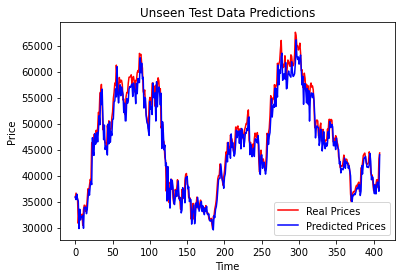

In [25]:
plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_baseline, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Model with NYSE Prices

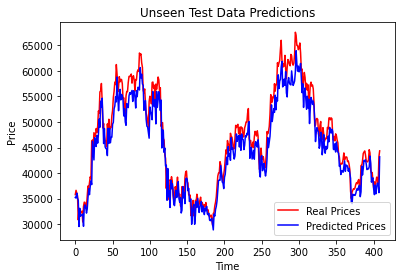

In [26]:
#Load the saved best model
load_file = 'models/rnn_nyse.hdf5'
rnn_best_nyse = load_model(load_file)

#Predict on test data
y_hat_raw_nyse = rnn_best_nyse.predict(X_test_nyse)
y_hat_nyse = btc_scaler.inverse_transform(y_hat_raw_nyse)
y_test_unscaled = btc_scaler.inverse_transform(y_test_nyse)

error_nyse = np.mean(np.absolute(((y_hat_nyse-y_test_unscaled)/y_test_unscaled)))

plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_nyse, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Model with Interest Rate

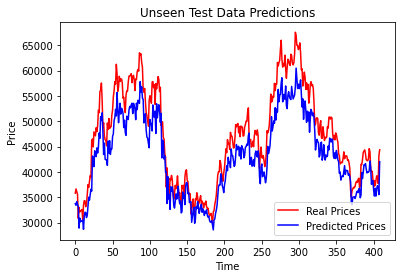

In [31]:
#Load the saved best model
load_file = 'models/rnn_int.hdf5'
rnn_best_int = load_model(load_file)

#Predict on test data
y_hat_raw_int = rnn_best_int.predict(X_test_int)
y_hat_int = btc_scaler.inverse_transform(y_hat_raw_int)
y_test_unscaled = btc_scaler.inverse_transform(y_test_int)

error_int_rate = np.mean(np.absolute(((y_hat_int-y_test_unscaled)/y_test_unscaled)))

plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_int, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Model with Gold Prices

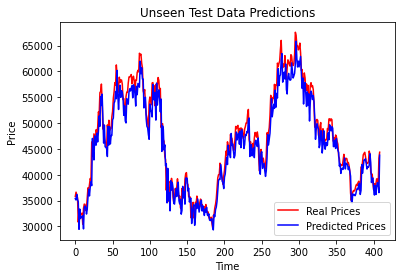

In [46]:
#Load the saved best model
load_file = 'models/rnn_gold.hdf5'
rnn_best_gold = load_model(load_file)

#Predict on test data
y_hat_raw_gold = rnn_best_gold.predict(X_test_gold)
y_hat_gold = btc_scaler.inverse_transform(y_hat_raw_gold)
y_test_unscaled = btc_scaler.inverse_transform(y_test_gold)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_gold, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;
error_gold = np.mean(np.absolute(((y_hat_gold-y_test_unscaled)/y_test_unscaled)))

Model with Nasdaq Prices

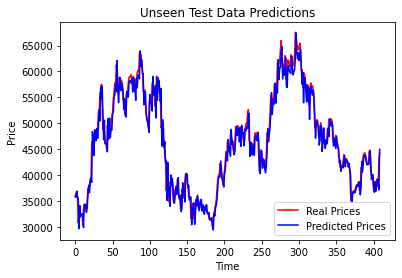

In [47]:
#Load the saved best model
load_file = 'models/rnn_nasdaq.hdf5'
rnn_best_nasdaq = load_model(load_file)

#Predict on test data
y_hat_raw_nasdaq = rnn_best_nasdaq.predict(X_test_nasdaq)
y_hat_nasdaq = btc_scaler.inverse_transform(y_hat_raw_nasdaq)
y_test_unscaled = btc_scaler.inverse_transform(y_test_nasdaq)


plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_nasdaq, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

error_nasdaq = np.mean(np.absolute(((y_hat_nasdaq-y_test_unscaled)/y_test_unscaled)))

Comp Model

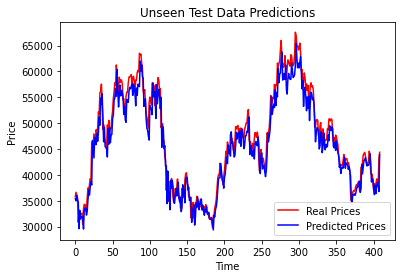

In [48]:
#Load the saved best model
load_file = 'models/rnn_comp.hdf5'
rnn_best_comp = load_model(load_file)

#Predict on test data
y_hat_raw_comp = rnn_best_comp.predict(X_test_comp)
y_hat_comp = btc_scaler.inverse_transform(y_hat_raw_comp)
y_test_unscaled = btc_scaler.inverse_transform(y_test_comp)

error_comp = np.mean(np.absolute(((y_hat_comp-y_test_unscaled)/y_test_unscaled)))
plt.plot(y_test_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_comp, color='blue', label='Predicted Prices')
plt.title('Unseen Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show
plt.savefig('charts/comp_model_predictions.png');

Best Model is Nasdaq Model with val-loss = 0.00016

In [49]:
error_baseline_w_dropout, error_baseline_2_layer, error_baseline, error_nyse, error_int_rate, error_gold, error_nasdaq, error_comp

(0.05977927761366827,
 0.07612077274846896,
 0.03640051567166835,
 0.04848430791041512,
 0.08087528939713128,
 0.04042373095451859,
 0.03413370472779941,
 0.039401201991748666)

<ipython-input-50-d0e547705c30>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, Fontsize=25)
<ipython-input-50-d0e547705c30>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(labels, Fontsize=25)
<ipython-input-50-d0e547705c30>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, Fontsize=25);
<ipython-input-50-d0e547705c30>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels(ylabels, Fontsize=25);


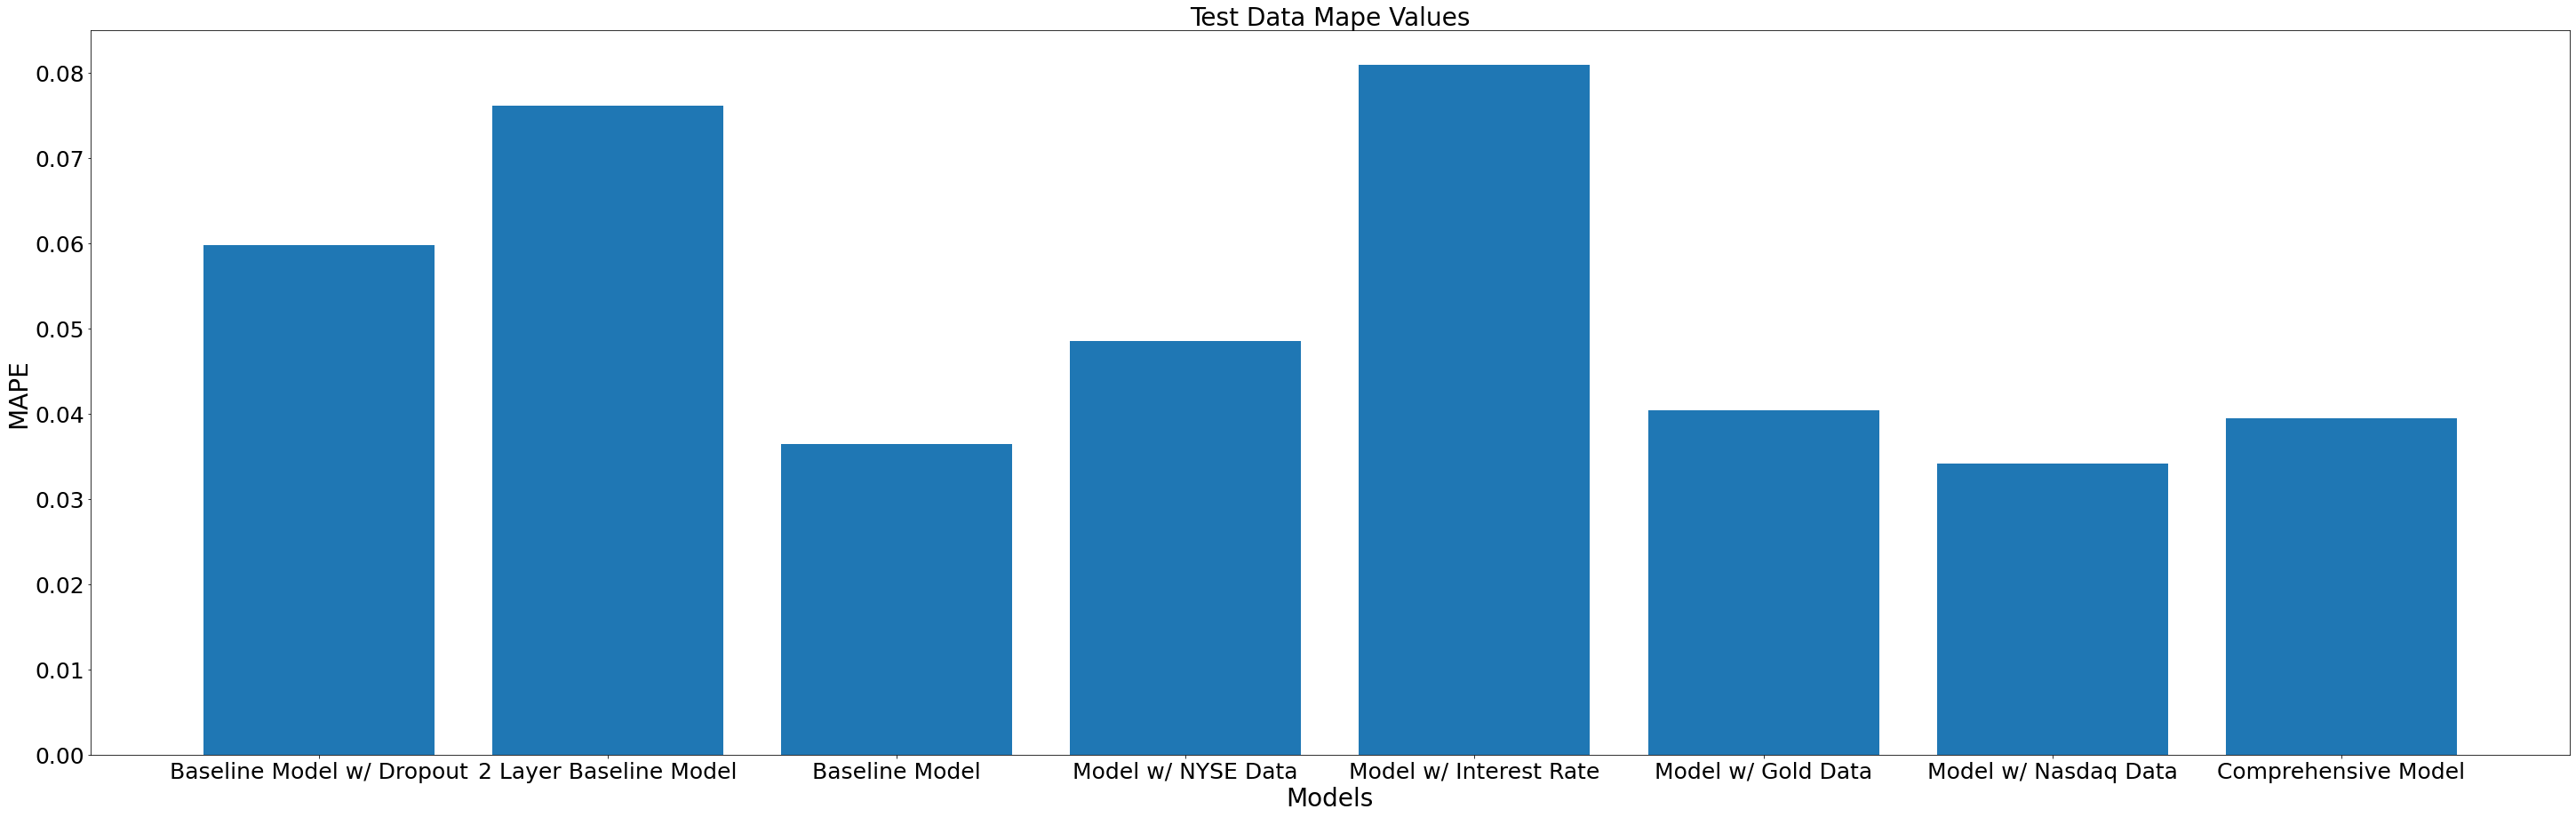

In [50]:
data = [error_baseline_w_dropout, error_baseline_2_layer, error_baseline, error_nyse, error_int_rate, error_gold, error_nasdaq, error_comp]
labels = ['Baseline Model w/ Dropout', '2 Layer Baseline Model', 'Baseline Model', 'Model w/ NYSE Data', 'Model w/ Interest Rate', 'Model w/ Gold Data', 'Model w/ Nasdaq Data', 'Comprehensive Model']
ylabels = ['0.00', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08']
fix, ax = plt.subplots(figsize=(50,15))

ax.bar(labels, data)
ax.set_title('Test Data Mape Values', fontsize=28)
ax.set_xlabel('Models', fontsize=28)
ax.set_xticklabels(labels, Fontsize=25)
ax.set_ylabel('MAPE', fontsize=28)
ax.set_yticklabels(ylabels, Fontsize=25);

# Investment Return Test Runs

### 30 Day Test Run with 10.000 USD

In [122]:
trial_run_df1 = pd.DataFrame()
trial_run_df1['Actual'] = [value[0] for value in y_test_unscaled[-31:]]
trial_run_df1['Prediction'] = [value[0] for value in y_hat_nasdaq[-31:]]

In [123]:
bank_balance1 = [10000]
coin_balance1 = [0]
coin_usd_balance1 = [0] 
usd1 = 10000
btc1 = 0
for day in range(1,31):
    if trial_run_df1.Prediction[day] > trial_run_df1.Actual[day-1]:
        if usd1 > btc1:
            print('Buy Bitcoin')
            btc1 = usd1 / trial_run_df1.Actual[day-1]
            usd1 = 0
        else:
            print('Keep Bitcoin')
    else:
        if usd1 > btc1:
            print('Do not buy BTC')
        else:
            print('Sell your BTC')
            usd1 = btc1 * trial_run_df1.Actual[day-1]
            btc1 = 0
    bank_balance1.append(usd1)
    coin_balance1.append(btc1)
    coin_usd_balance1.append(btc1 * trial_run_df1.Actual[day-1])
total_balance1 = np.array(bank_balance1) + np.array(coin_usd_balance1) 

Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin


In [118]:
btc_30_day_change = (btc_df.Close[-1] - btc_df.Close[-30]) / btc_df.Close[-30]
nasdaq_30_day_change = (nasdaq_df.Close[-1] - nasdaq_df.Close[-30]) / nasdaq_df.Close[-30]
nyse_30_day_change = (nyse_df.Close[-1] - nyse_df.Close[-30]) / nyse_df.Close[-30]
gold_30_day_change = (gold_df.Close[-1] - gold_df.Close[-30]) / gold_df.Close[-30]
model_30_day_performance = (total_balance1[-1] - total_balance1[0]) / total_balance1[0]

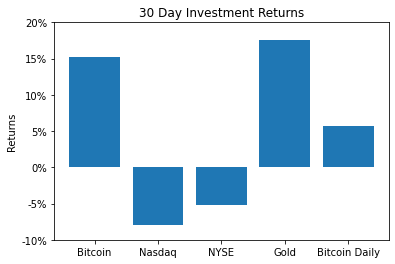

In [132]:
plot_data1 = [btc_30_day_change, nasdaq_30_day_change, nyse_30_day_change, gold_30_day_change, model_30_day_performance]
plot_labels1 = ['Bitcoin' , 'Nasdaq', 'NYSE', 'Gold', 'Bitcoin Daily']
plt.bar(plot_labels1, plot_data1)
plt.title('30 Day Investment Returns')
plt.ylabel('Returns')
plt.yticks(np.arange(-.10,.20, .05),['-10%', '-5%', '0%', '5%', '10%', '15%','20%'])
plt.show;

### 60 Day Test Run with 10.000 USD

In [149]:
trial_run_df2 = pd.DataFrame()
trial_run_df2['Actual'] = [value[0] for value in y_test_unscaled[-61:]]
trial_run_df2['Prediction'] = [value[0] for value in y_hat_nasdaq[-61:]]

In [150]:
bank_balance2 = [10000]
coin_balance2 = [0]
coin_usd_balance2 = [0] 
usd2 = 10000
btc2 = 0
for day in range(1,61):
    if trial_run_df2.Prediction[day] > trial_run_df2.Actual[day-1]:
        if usd2 > btc2:
            print('Buy Bitcoin')
            btc2 = usd2 / trial_run_df2.Actual[day-1]
            usd2 = 0
        else:
            print('Keep Bitcoin')
    else:
        if usd2 > btc2:
            print('Do not buy BTC')
        else:
            print('Sell your BTC')
            usd2 = btc2 * trial_run_df2.Actual[day-1]
            btc2 = 0
    bank_balance2.append(usd2)
    coin_balance2.append(btc2)
    coin_usd_balance2.append(btc2 * trial_run_df2.Actual[day-1])
total_balance2 = np.array(bank_balance2) + np.array(coin_usd_balance2) 

Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Keep Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin


In [151]:
btc_60_day_change = (btc_df.Close[-1] - btc_df.Close[-60]) / btc_df.Close[-60]
nasdaq_60_day_change = (nasdaq_df.Close[-1] - nasdaq_df.Close[-60]) / nasdaq_df.Close[-60]
nyse_60_day_change = (nyse_df.Close[-1] - nyse_df.Close[-60]) / nyse_df.Close[-60]
gold_60_day_change = (gold_df.Close[-1] - gold_df.Close[-60]) / gold_df.Close[-60]
model_60_day_performance = (total_balance2[-1] - total_balance2[1]) / total_balance2[1]


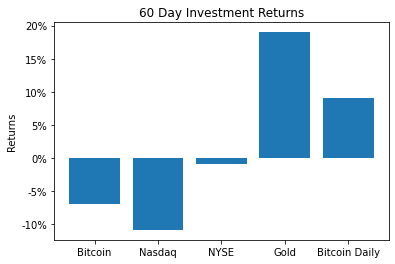

In [152]:
plot_data2 = [btc_60_day_change, nasdaq_60_day_change, nyse_60_day_change, gold_60_day_change, model_60_day_performance]
plot_labels2 = ['Bitcoin' , 'Nasdaq', 'NYSE', 'Gold', 'Bitcoin Daily']
plt.bar(plot_labels2, plot_data2)
plt.title('60 Day Investment Returns')
plt.ylabel('Returns')
plt.yticks(np.arange(-.10,.20, .05),['-10%', '-5%', '0%', '5%', '10%', '15%','20%'])
plt.show;

### 180 Day Test Run with 10.000 USD

In [145]:
trial_run_df3 = pd.DataFrame()
trial_run_df3['Actual'] = [value[0] for value in y_test_unscaled[-181:]]
trial_run_df3['Prediction'] = [value[0] for value in y_hat_nasdaq[-181:]]

In [146]:
bank_balance3 = [10000]
coin_balance3 = [0]
coin_usd_balance3 = [0] 
usd3 = 10000
btc3 = 0
for day in range(1,181):
    if trial_run_df3.Prediction[day] > trial_run_df3.Actual[day-1]:
        if usd3 > btc3:
            print('Buy Bitcoin')
            btc3 = usd3 / trial_run_df3.Actual[day-1]
            usd3 = 0
        else:
            print('Keep Bitcoin')
    else:
        if usd3 > btc3:
            print('Do not buy BTC')
        else:
            print('Sell your BTC')
            usd3 = btc3 * trial_run_df3.Actual[day-1]
            btc3 = 0
    bank_balance3.append(usd3)
    coin_balance3.append(btc3)
    coin_usd_balance3.append(btc3 * trial_run_df3.Actual[day-1])
total_balance3 = np.array(bank_balance3) + np.array(coin_usd_balance3) 

Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not 

In [172]:
btc_180_day_change = (btc_df.Close[-1] - btc_df.Close[-180]) / btc_df.Close[-180]
nasdaq_180_day_change = (nasdaq_df.Close[-1] - nasdaq_df.Close[-180]) / nasdaq_df.Close[-180]
nyse_180_day_change = (nyse_df.Close[-1] - nyse_df.Close[-180]) / nyse_df.Close[-180]
gold_180_day_change = (gold_df.Close[-1] - gold_df.Close[-180]) / gold_df.Close[-180]
model_180_day_performance = (total_balance3[-1] - total_balance3[1]) / total_balance3[1]


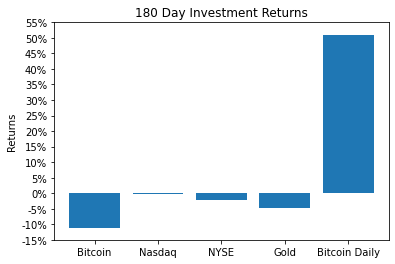

In [179]:
plot_data3 = [btc_180_day_change, nasdaq_180_day_change, nyse_180_day_change, gold_180_day_change, model_180_day_performance]
plot_labels3 = ['Bitcoin' , 'Nasdaq', 'NYSE', 'Gold', 'Bitcoin Daily']
plt.bar(plot_labels3, plot_data3)
plt.title('180 Day Investment Returns')
plt.ylabel('Returns')
plt.yticks(np.arange(-.15,.60, .05),['-15%','-10%', '-5%', '0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%', '45%', '50%', '55%'])
plt.show;

### 365 Day Test Run with 10.000 USD

In [153]:
trial_run_df4 = pd.DataFrame()
trial_run_df4['Actual'] = [value[0] for value in y_test_unscaled[-366:]]
trial_run_df4['Prediction'] = [value[0] for value in y_hat_nasdaq[-366:]]

In [155]:
bank_balance4 = [10000]
coin_balance4 = [0]
coin_usd_balance4 = [0] 
usd4 = 10000
btc4 = 0
for day in range(1,366):
    if trial_run_df4.Prediction[day] > trial_run_df4.Actual[day-1]:
        if usd4 > btc4:
            print('Buy Bitcoin')
            btc4 = usd4 / trial_run_df4.Actual[day-1]
            usd4 = 0
        else:
            print('Keep Bitcoin')
    else:
        if usd4 > btc4:
            print('Do not buy BTC')
        else:
            print('Sell your BTC')
            usd4 = btc4 * trial_run_df4.Actual[day-1]
            btc4 = 0
    bank_balance4.append(usd4)
    coin_balance4.append(btc4)
    coin_usd_balance4.append(btc4 * trial_run_df4.Actual[day-1])
total_balance4 = np.array(bank_balance4) + np.array(coin_usd_balance4) 

Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy

In [174]:
btc_365_day_change = (btc_df.Close[-1] - btc_df.Close[-365]) / btc_df.Close[-365]
nasdaq_365_day_change = (nasdaq_df.Close[-1] - nasdaq_df.Close[-365]) / nasdaq_df.Close[-365]
nyse_365_day_change = (nyse_df.Close[-1] - nyse_df.Close[-365]) / nyse_df.Close[-365]
gold_365_day_change = (gold_df.Close[-1] - gold_df.Close[-365]) / gold_df.Close[-365]
model_365_day_performance = (total_balance4[-1] - total_balance4[1]) / total_balance4[1]


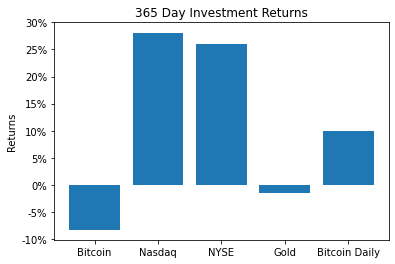

In [175]:
plot_data4 = [btc_365_day_change, nasdaq_365_day_change, nyse_365_day_change, gold_365_day_change, model_365_day_performance]
plot_labels4 = ['Bitcoin' , 'Nasdaq', 'NYSE', 'Gold', 'Bitcoin Daily']
plt.bar(plot_labels4, plot_data4)
plt.title('365 Day Investment Returns')
plt.ylabel('Returns')
plt.yticks(np.arange(-.10,.35, .05),['-10%', '-5%', '0%', '5%', '10%', '15%','20%', '25%','30%'])
plt.show;

### 408 Day Test Run with 10.000 USD

In [158]:
trial_run_df5 = pd.DataFrame()
trial_run_df5['Actual'] = [value[0] for value in y_test_unscaled[-409:]]
trial_run_df5['Prediction'] = [value[0] for value in y_hat_nasdaq[-409:]]

In [159]:
bank_balance5 = [10000]
coin_balance5 = [0]
coin_usd_balance5 = [0] 
usd5 = 10000
btc5 = 0
for day in range(1,409):
    if trial_run_df5.Prediction[day] > trial_run_df5.Actual[day-1]:
        if usd5 > btc5:
            print('Buy Bitcoin')
            btc5 = usd5 / trial_run_df5.Actual[day-1]
            usd5 = 0
        else:
            print('Keep Bitcoin')
    else:
        if usd5 > btc5:
            print('Do not buy BTC')
        else:
            print('Sell your BTC')
            usd5 = btc5 * trial_run_df5.Actual[day-1]
            btc5 = 0
    bank_balance5.append(usd5)
    coin_balance5.append(btc5)
    coin_usd_balance5.append(btc5 * trial_run_df5.Actual[day-1])
total_balance5 = np.array(bank_balance5) + np.array(coin_usd_balance5) 

Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Keep Bitcoin
Keep Bitcoin
Sell your BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Keep Bitcoin
Keep Bitcoin
Sell your BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Keep Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Buy Bitcoin
Sell your BTC
Do not buy BTC
Do not buy BTC
Do not buy BTC
Do 

In [176]:
btc_408_day_change = (btc_df.Close[-1] - btc_df.Close[-408]) / btc_df.Close[-408]
nasdaq_408_day_change = (nasdaq_df.Close[-1] - nasdaq_df.Close[-408]) / nasdaq_df.Close[-408]
nyse_408_day_change = (nyse_df.Close[-1] - nyse_df.Close[-408]) / nyse_df.Close[-408]
gold_408_day_change = (gold_df.Close[-1] - gold_df.Close[-408]) / gold_df.Close[-408]
model_408_day_performance = (total_balance5[-1] - total_balance5[1]) / total_balance5[1]


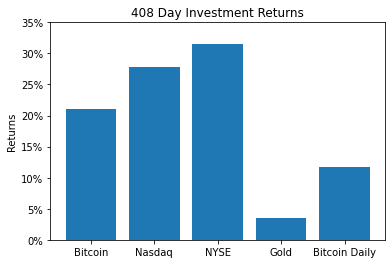

In [177]:
plot_data5 = [btc_408_day_change, nasdaq_408_day_change, nyse_408_day_change, gold_408_day_change, model_408_day_performance]
plot_labels5 = ['Bitcoin' , 'Nasdaq', 'NYSE', 'Gold', 'Bitcoin Daily']
plt.bar(plot_labels5, plot_data5)
plt.title('408 Day Investment Returns')
plt.ylabel('Returns')
plt.yticks(np.arange(0,.40, .05),['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%'])
plt.show;

In [178]:
model_408_day_performance, model_365_day_performance, model_180_day_performance, model_60_day_performance, model_30_day_performance

(0.11735381173847327,
 0.09864432051529876,
 0.5084182110833851,
 0.09000329701008887,
 0.05660331539382496)